# Computing the scores of BLEU out of mongo texts into csv

In [31]:
from pymongo import MongoClient
from sacrebleu import corpus_bleu
import pandas as pd
from tqdm import tqdm

def calculate_bleu_scores_per_doc_lowercase(tokenize: str = "13a"):
    """
    Berechnet pro Dokument den BLEU-Score (case-insensitive),
    verwendet dabei die Felder `text` und `srcText`.
    """
    client = MongoClient("mongodb://localhost:27018/")
    coll   = client["transcriptions"]["transcripts_denis"]

    rows = []
    for doc in tqdm(coll.find({"excludeGeneral": 0}), desc="BLEU per Doc (lowercase)"):
        hyp = doc.get("text", "")
        ref = doc.get("srcText", "")   # hier war der Tippfehler

        if not hyp or not ref:
            continue

        score = corpus_bleu(
            [hyp],
            [[ref]],
            lowercase=True,
            tokenize=tokenize
        ).score

        rows.append({
            "convoID":         doc.get("convoID"),
            "ambientVariant":  doc.get("ambientVariant"),
            "processedVolume": doc.get("processedVolume"),
            "technology":      doc.get("technology"),
            "model":           doc.get("model"),
            "bleu_score":      score
        })

    client.close()
    return pd.DataFrame(rows)

if __name__ == "__main__":
    df_bleu = calculate_bleu_scores_per_doc_lowercase()
    print("Gefundene Zeilen:", len(df_bleu))
    df_bleu.to_csv("bleu_scores_per_doc.csv", index=False, encoding="utf-8-sig")
    print("Per-document BLEU scores (lowercase) gespeichert in bleu_scores_per_doc.csv")


BLEU per Doc (lowercase): 11880it [02:36, 76.09it/s] 

Gefundene Zeilen: 11880
Per-document BLEU scores (lowercase) gespeichert in bleu_scores_per_doc.csv


## Checks

# Statistics

## Descriptive

In [12]:
# %%  
# 1) Deskriptive Statistik über alle Dokumente (BLEU)
import pandas as pd

# CSV einlesen
df_bleu = pd.read_csv("bleu_scores_per_doc.csv")

# Kennzahlen berechnen
overall = df_bleu["bleu_score"].agg(["mean", "median", "std", "min", "max"])
print("=== Overall BLEU ===")
print(overall, "\n")



=== Overall BLEU ===
mean      56.807909
median    78.827031
std       36.418826
min        0.000349
max       95.822741
Name: bleu_score, dtype: float64 



In [14]:
# %%  
# 2) Gruppiert nach Technologie & Modell
import pandas as pd

df_bleu = pd.read_csv("bleu_scores_per_doc.csv")

# Gruppieren und Kennzahlen berechnen
grouped = df_bleu.groupby(["technology", "model"])["bleu_score"]
stats = grouped.agg(["mean", "median", "std", "min", "max"]).reset_index()

print("=== BLEU by Technology & Model ===")
print(stats)



=== BLEU by Technology & Model ===
   technology                 model       mean     median       std  \
0      recapp       gsw-CH_smoothed  85.283214  87.305809  8.344152   
1        vosk    vosk-model-de-0.21  13.465349  14.468285  4.251786   
2     whisper                 large  79.769338  81.180336  8.291796   
3     whisper                medium  80.492361  82.515336  9.199743   
4     whisper                 turbo  81.826870  84.028445  9.320628   
5  whisper_v2  whisper_rescuespeech   0.010323   0.008100  0.005210   

         min        max  
0  38.893048  95.822741  
1   0.293999  22.185858  
2  39.739646  94.442762  
3  33.921019  94.482684  
4  38.518477  94.635053  
5   0.000349   0.026520  


In [3]:
stats

,technology,model,mean,median,std,min,max
0,recapp,gsw-CH_smoothed,85.283214,87.305809,8.344152,38.893048,95.822741
1,vosk,vosk-model-de-0.21,13.465349,14.468285,4.251786,0.293999,22.185858
2,whisper,large,79.769338,81.180336,8.291796,39.739646,94.442762
3,whisper,medium,80.492361,82.515336,9.199743,33.921019,94.482684
4,whisper,turbo,81.826870,84.028445,9.320628,38.518477,94.635053
5,whisper_v2,whisper_rescuespeech,0.010323,0.008100,0.005210,0.000349,0.026520


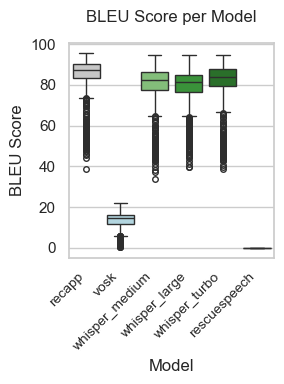

Plot saved at: results_for_paper/bleu_boxplot.png


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1) Daten laden
csv_path = "bleu_scores_per_doc.csv"
df = pd.read_csv(csv_path)
df["system"] = df["technology"] + "–" + df["model"]

# 2) Kürzere Labels mappen (analog zu WER/Lex)
label_map = {
    "recapp–gsw-CH_smoothed":         "recapp",
    "vosk–vosk-model-de-0.21":         "vosk",
    "whisper–medium":                  "whisper_medium",
    "whisper–large":                   "whisper_large",
    "whisper–turbo":                   "whisper_turbo",
    "whisper_v2–whisper_rescuespeech": "rescuespeech"
}
df["label"] = df["system"].map(label_map)

# 3) Reihenfolge & Farben übernehmen
order = [lbl for lbl in ["recapp","vosk","whisper_medium","whisper_large","whisper_turbo","rescuespeech"]
         if lbl in df["label"].unique()]
palette = {
    "recapp":         "#c6c6c6",
    "vosk":           "#aad9e6",
    "whisper_medium": "#7bc96f",
    "whisper_large":  "#2ca02c",
    "whisper_turbo":  "#1f7a1f",
    "rescuespeech":   "#fdb064"
}

# 4) Plot-Settings wie beim WER
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(3, 4))

# 5) Boxplot zeichnen mit schwarzen Ausreißermarkern
flierprops = dict(marker='o', color='black', markersize=4)
ax = sns.boxplot(
    data=df,
    x="label",
    y="bleu_score",
    order=order,
    palette=palette,
    flierprops=flierprops
)

# 6) Titel und Achsenbeschriftungen
ax.set_title("BLEU Score per Model", pad=15)
ax.set_xlabel("Model")
ax.set_ylabel("BLEU Score")

# 7) X‑Ticks drehen
plt.xticks(rotation=45, ha="right", fontsize=10)

# 8) Ordner für Ergebnisse erstellen
output_dir = os.path.join(os.path.dirname(csv_path), "results_for_paper")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 9) Plot speichern
output_png = os.path.join(output_dir, "bleu_boxplot.png")
plt.tight_layout()
plt.savefig(output_png, format="png", dpi=300)

# 10) Plot anzeigen und Pfad ausgeben
plt.show()
print(f"Plot saved at: {output_png}")



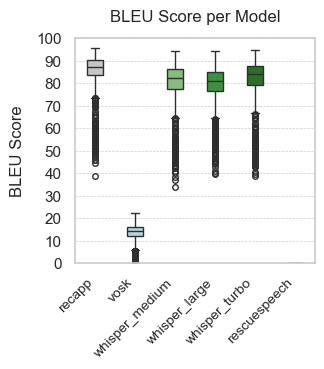

Plot saved at: results_for_paper/bleu_boxplot_fixed.png


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1) Daten laden
csv_path = "bleu_scores_per_doc.csv"
df = pd.read_csv(csv_path)
df["system"] = df["technology"] + "–" + df["model"]

# 2) Kürzere Labels mappen
label_map = {
    "recapp–gsw-CH_smoothed":         "recapp",
    "vosk–vosk-model-de-0.21":         "vosk",
    "whisper–medium":                  "whisper_medium",
    "whisper–large":                   "whisper_large",
    "whisper–turbo":                   "whisper_turbo",
    "whisper_v2–whisper_rescuespeech": "rescuespeech"
}
df["label"] = df["system"].map(label_map)

# 3) Reihenfolge & Farben übernehmen
order = [lbl for lbl in ["recapp","vosk","whisper_medium","whisper_large","whisper_turbo","rescuespeech"]
         if lbl in df["label"].unique()]
palette = {
    "recapp":         "#c6c6c6",
    "vosk":           "#aad9e6",
    "whisper_medium": "#7bc96f",
    "whisper_large":  "#2ca02c",
    "whisper_turbo":  "#1f7a1f",
    "rescuespeech":   "#fdb064"
}

# 4) Plot‑Style
sns.set(style="whitegrid", font_scale=1.0)

# 5) Figure & Axes absolut setzen (Template)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0.12, 0.18, 0.80, 0.75])

# 6) Boxplot zeichnen
flierprops = dict(marker='o', color='black', markersize=4)
sns.boxplot(
    data=df,
    x="label",
    y="bleu_score",
    order=order,
    palette=palette,
    flierprops=flierprops,
    ax=ax,
    width=0.4
)

# 7) Titel, Achsenbeschriftungen & fixe Y‑Skala 0–100
ax.set_title("BLEU Score per Model", pad=12)
ax.set_xlabel("")
ax.set_ylabel("BLEU Score", labelpad=8)
ax.set_ylim(0, 100)

# 8) Einheitliche Grid‑Linien bei 10er-Schritten
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.grid(axis="y", which="major", linestyle="--", linewidth=0.5)

# 9) X‑Ticks rotieren
ax.set_xticklabels(order, rotation=45, ha="right", fontsize=10)

# 10) Subplots Adjust für korrekte Ränder
fig.subplots_adjust(top=0.90, left=0.12, right=0.92, bottom=0.15)

# 11) Ergebnis‑Ordner & Speichern
output_dir = os.path.join(os.path.dirname(csv_path), "results_for_paper")
os.makedirs(output_dir, exist_ok=True)
output_png = os.path.join(output_dir, "bleu_boxplot_fixed.png")
fig.savefig(output_png, format="png", dpi=300, bbox_inches='tight', pad_inches=0.1)

# 12) Anzeige & Pfad
plt.show()
print(f"Plot saved at: {output_png}")


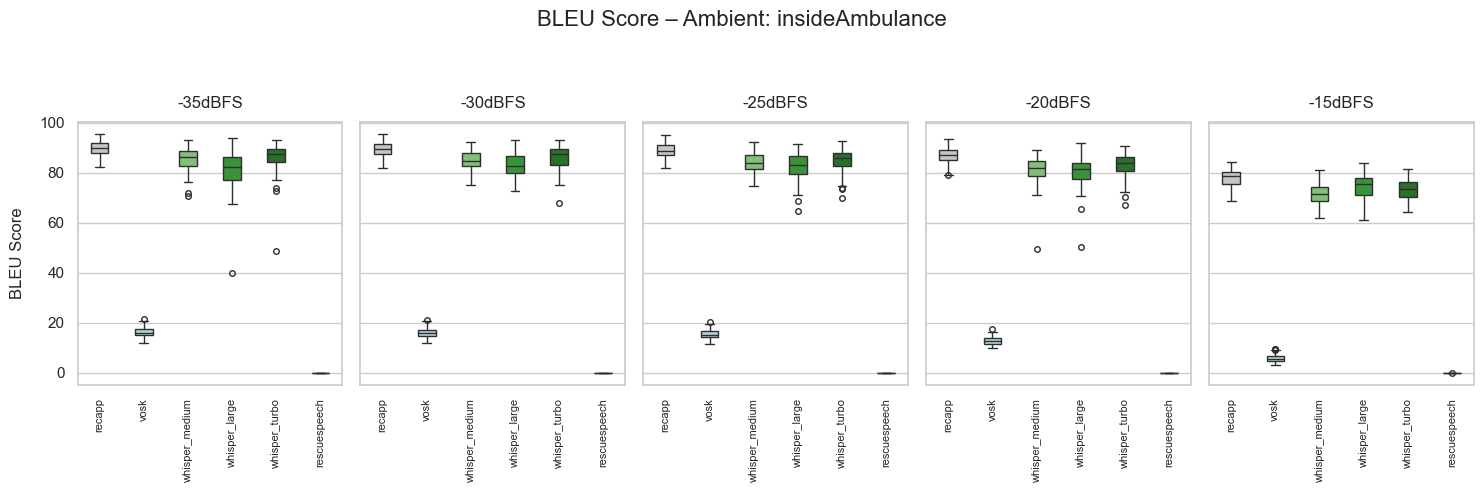

Plot saved at: results_for_paper/bleu_boxplot_insideAmbulance.png


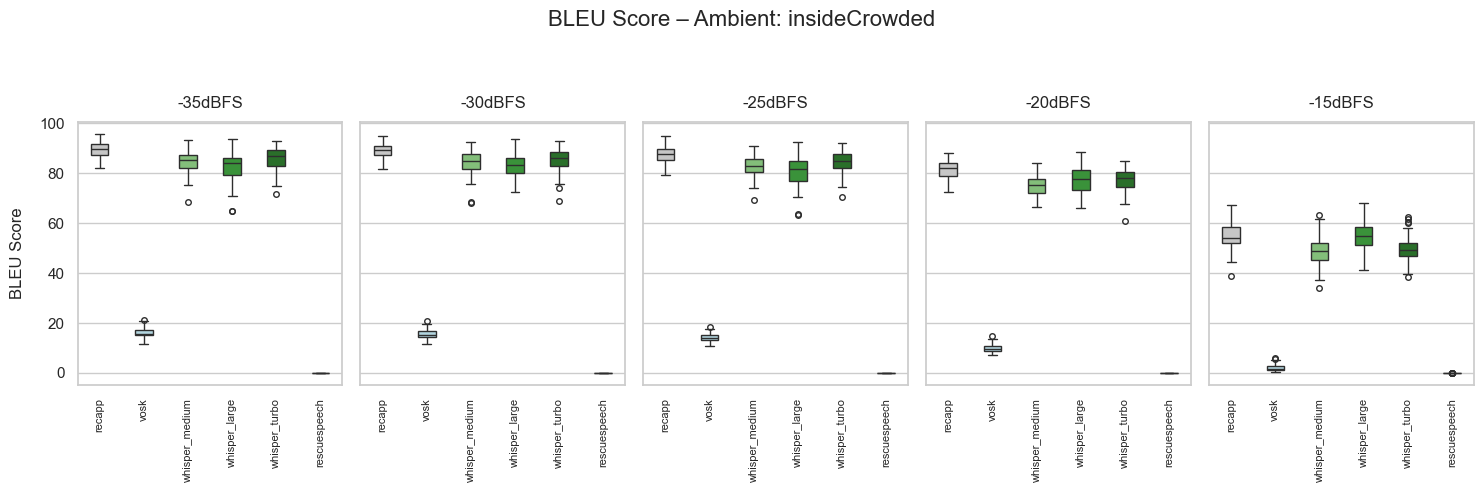

Plot saved at: results_for_paper/bleu_boxplot_insideCrowded.png


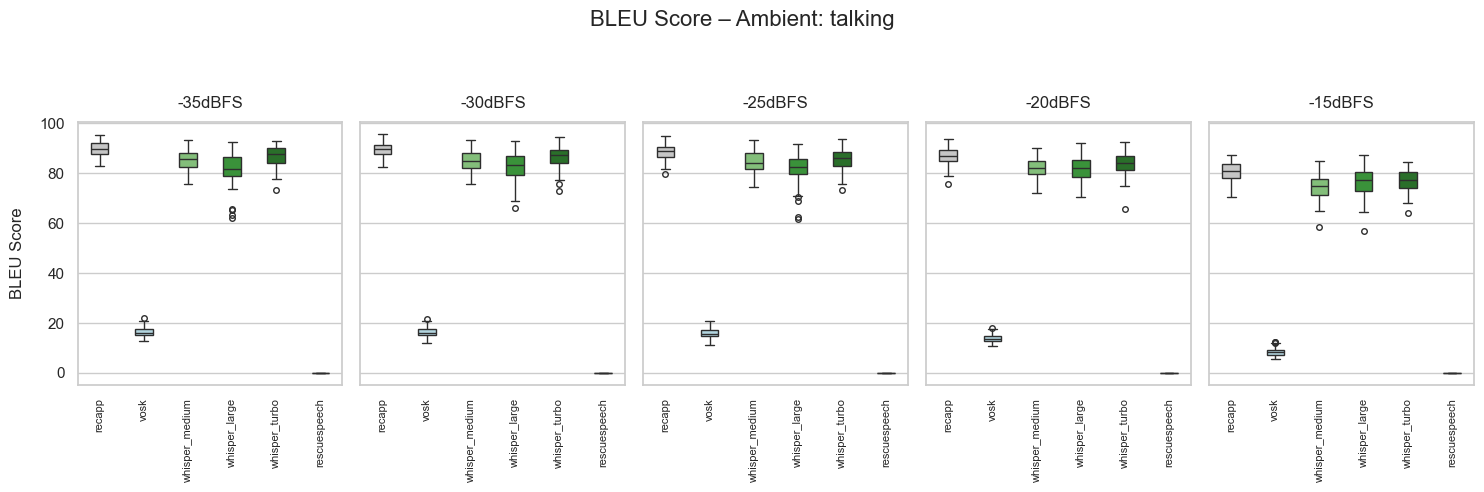

Plot saved at: results_for_paper/bleu_boxplot_talking.png


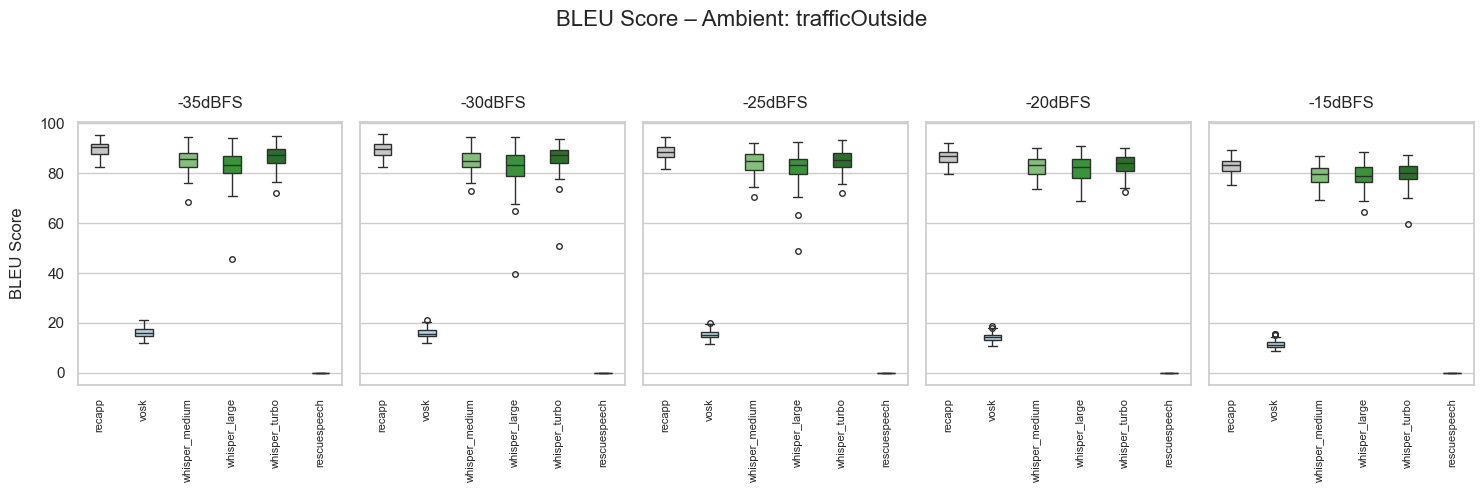

Plot saved at: results_for_paper/bleu_boxplot_trafficOutside.png


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1) Daten laden
csv_path = "bleu_scores_per_doc.csv"
df = pd.read_csv(csv_path)
df["system"] = df["technology"] + "–" + df["model"]

# 2) Kurze Labels mappen (wie zuvor)
label_map = {
    "recapp–gsw-CH_smoothed":         "recapp",
    "vosk–vosk-model-de-0.21":         "vosk",
    "whisper–medium":                  "whisper_medium",
    "whisper–large":                   "whisper_large",
    "whisper–turbo":                   "whisper_turbo",
    "whisper_v2–whisper_rescuespeech": "rescuespeech"
}
df["label"] = df["system"].map(label_map)

# 3) Reihenfolge & Farben übernehmen
order = ["recapp","vosk","whisper_medium","whisper_large","whisper_turbo","rescuespeech"]
palette = {
    "recapp":         "#c6c6c6",
    "vosk":           "#aad9e6",
    "whisper_medium": "#7bc96f",
    "whisper_large":  "#2ca02c",
    "whisper_turbo":  "#1f7a1f",
    "rescuespeech":   "#fdb064"
}

# 4) Volumen-Kategorien festlegen
volumes = ["-35dBFS","-30dBFS","-25dBFS","-20dBFS","-15dBFS"]

sns.set(style="whitegrid", font_scale=1.0)

# Ordner für Ergebnisse erstellen
output_dir = os.path.join(os.path.dirname(csv_path), "results_for_paper")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 5) Schleife über Ambient-Varianten
for amb in sorted(df["ambientVariant"].unique()):
    subset_amb = df[df["ambientVariant"] == amb]
    if subset_amb.empty:
        continue

    fig, axes = plt.subplots(1, len(volumes), figsize=(len(volumes)*3, 5), sharey=True)

    # Subplots zeichnen
    for idx, vol in enumerate(volumes):
        ax = axes[idx]
        sub = subset_amb[subset_amb["processedVolume"] == vol]
        sns.boxplot(
            data=sub,
            x="label", y="bleu_score",
            order=order, palette=palette,
            ax=ax, width=0.4, flierprops=dict(marker='o', color='black', markersize=4)
        )
        ax.set_title(vol, pad=10)
        ax.set_xlabel("")
        if idx == 0:
            ax.set_ylabel("BLEU Score", labelpad=10)
        else:
            ax.set_ylabel("")
        ax.set_xticklabels(order, rotation=90, ha="center", fontsize=8)

    # Supertitel setzen und Layout justieren
    fig.suptitle(f"BLEU Score – Ambient: {amb}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])

    # Als PNG speichern
    output_png = os.path.join(output_dir, f"bleu_boxplot_{amb}.png")
    fig.savefig(output_png, format="png", dpi=300)

    # Anzeigen und Pfad ausgeben
    plt.show()
    print(f"Plot saved at: {output_png}")

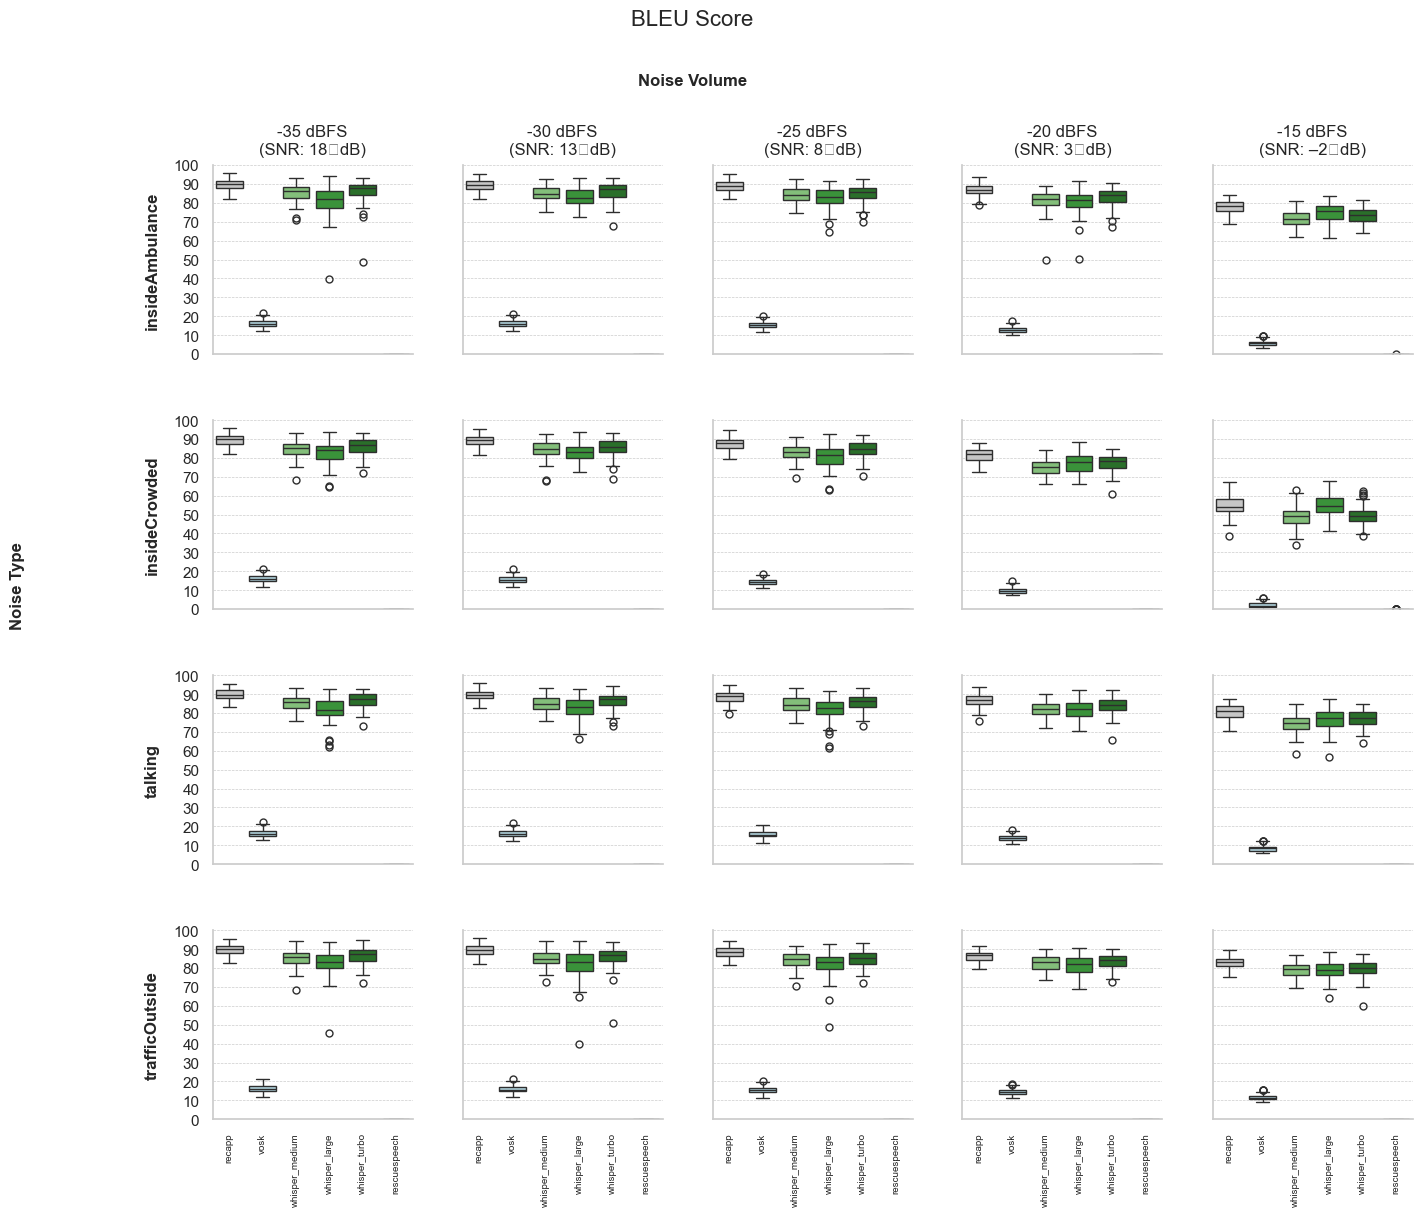

Plot saved at: results_for_paper/bleu_facetgrid.png


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1) Daten laden
csv_path = "bleu_scores_per_doc.csv"
df = pd.read_csv(csv_path)
df["system"] = df["technology"] + "–" + df["model"]

# 2) Labels mappen
label_map = {
    "recapp–gsw-CH_smoothed":         "recapp",
    "vosk–vosk-model-de-0.21":         "vosk",
    "whisper–medium":                  "whisper_medium",
    "whisper–large":                   "whisper_large",
    "whisper–turbo":                   "whisper_turbo",
    "whisper_v2–whisper_rescuespeech": "rescuespeech"
}
df["label"] = df["system"].map(label_map)

# 3) Reihenfolge & Farben
order = ["recapp","vosk","whisper_medium","whisper_large","whisper_turbo","rescuespeech"]
palette = {
    "recapp":         "#c6c6c6",
    "vosk":           "#aad9e6",
    "whisper_medium": "#7bc96f",
    "whisper_large":  "#2ca02c",
    "whisper_turbo":  "#1f7a1f",
    "rescuespeech":   "#fdb064"
}

# 4) dBFS- & Ambient-Varianten inkl. SNR-Labels
volumes = ["-35dBFS","-30dBFS","-25dBFS","-20dBFS","-15dBFS"]
vol_labels = {
    "-35dBFS": "-35 dBFS\n(SNR: 18 dB)",
    "-30dBFS": "-30 dBFS\n(SNR: 13 dB)",
    "-25dBFS": "-25 dBFS\n(SNR: 8 dB)",
    "-20dBFS": "-20 dBFS\n(SNR: 3 dB)",
    "-15dBFS": "-15 dBFS\n(SNR: –2 dB)"
}
ambients = sorted(df["ambientVariant"].unique())

sns.set(style="whitegrid", font_scale=1.0)

# 5) FacetGrid für BLEU
g = sns.catplot(
    data=df,
    x="label", y="bleu_score",
    row="ambientVariant", col="processedVolume",
    kind="box",
    order=order, palette=palette,
    height=3, aspect=1,
    sharey=True, margin_titles=True, legend=False,
    col_order=volumes, row_order=ambients
)

# 6) Default-Titles entfernen
g.set_titles(row_template="", col_template="")

# 7) Abstände & Haupttitel
g.fig.subplots_adjust(
    top=0.85,
    left=0.18,
    right=0.98,
    hspace=0.35,
    wspace=0.25
)
g.fig.suptitle("BLEU Score", fontsize=16)

# 8) Noise Volume-Label über den Columns
g.fig.text(
    0.50, 0.92,
    "Noise Volume",
    ha="center", va="center",
    fontsize=12, fontweight="bold"
)

# 9) Manuelle Column-Titles mit SNR
for idx, vol in enumerate(volumes):
    ax = g.axes[0][idx]
    ax.set_title(vol_labels[vol], pad=8)

# 10) Feintuning jedes Facets mit Y‑Range 0–100
for row_idx, amb in enumerate(ambients):
    for col_idx, vol in enumerate(volumes):
        ax = g.axes[row_idx][col_idx]
        ax.set_ylim(0, 100)  # Y-Achse 0 bis 100
        ax.yaxis.set_major_locator(MultipleLocator(10))  # Grid alle 10
        ax.grid(axis="y", which="major", linestyle="--", linewidth=0.5)
        ax.set_xticklabels(order, rotation=90, ha="center", fontsize=7)
        ax.set_xlabel("")  
        ax.set_ylabel("")

    # Manuelles Ambient-Label links außen
    ax0 = g.axes[row_idx][0]
    ax0.text(
        -0.30, 0.5, amb,
        ha="center", va="center",
        rotation=90, transform=ax0.transAxes,
        fontsize=12, fontweight="bold"
    )

# 11) Ein einziges Y‑Achsen-Label links außen
g.fig.text(
    0.05, 0.5,
    "Noise Type",
    ha="center", va="center",
    rotation="vertical",
    fontsize=12, fontweight="bold"
)

# 12) Ergebnis-Ordner anlegen & speichern
output_dir = os.path.join(os.path.dirname(csv_path), "results_for_paper")
os.makedirs(output_dir, exist_ok=True)
output_png = os.path.join(output_dir, "bleu_facetgrid.png")
g.fig.savefig(output_png, format="png", dpi=300)

# 13) Plot anzeigen & Pfad ausgeben
plt.show()
print(f"Plot saved at: {output_png}")


# Inferenz

In [19]:
# %%  
# OLS mit festen Baselines & cluster‐robusten SEs für BLEU
import pandas as pd
import statsmodels.formula.api as smf

# 1) Daten laden
df = pd.read_csv("bleu_scores_per_doc.csv")

# 2) System-Faktor mit gewünschter Baseline 'recapp–gsw-CH_smoothed'
df["system"] = df["technology"] + "–" + df["model"]
sys_levels = list(df["system"].unique())
sys_levels.remove("recapp–gsw-CH_smoothed")
sys_levels = ["recapp–gsw-CH_smoothed"] + sys_levels
df["system"] = pd.Categorical(df["system"], categories=sys_levels)

# 3) AmbientVariant mit Baseline 'trafficOutside'
av_levels = list(df["ambientVariant"].unique())
av_levels.remove("trafficOutside")
av_levels = ["trafficOutside"] + av_levels
df["ambientVariant"] = pd.Categorical(df["ambientVariant"], categories=av_levels)

# 4) ProcessedVolume mit Baseline '-35dBFS'
pv_levels = list(df["processedVolume"].unique())
pv_levels.remove("-35dBFS")
pv_levels = ["-35dBFS"] + pv_levels
df["processedVolume"] = pd.Categorical(df["processedVolume"], categories=pv_levels)

# 5) OLS starten und Cluster‐robuste SEs auf convoID
formula = "bleu_score ~ C(system) + C(ambientVariant) + C(processedVolume)"
ols = smf.ols(formula, data=df).fit()
ols_clust = ols.get_robustcov_results(
    cov_type="cluster",
    groups=df["convoID"]
)

# 6) Ergebnisse ausgeben
print("=== BLEU OLS Regression (cluster‐robust SE) ===")
print(ols_clust.summary())



=== BLEU OLS Regression (cluster‐robust SE) ===
                            OLS Regression Results                            
Dep. Variable:             bleu_score   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     8415.
Date:                Fri, 25 Jul 2025   Prob (F-statistic):          6.91e-142
Time:                        12:39:07   Log-Likelihood:                -37391.
No. Observations:               11880   AIC:                         7.481e+04
Df Residuals:                   11867   BIC:                         7.490e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [20]:
# -----------------------
# 6) Multikollinearität prüfen (VIF)
#    Design-Matrix aus dem gefitteten ols-Objekt
X = ols.model.exog
names = ols.model.exog_names

vif = pd.DataFrame({
    "variable": names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

print("=== VIF ===")
print(vif)



=== VIF ===
                                        variable        VIF
0                                      Intercept  13.000000
1                     C(system)[T.whisper–large]   1.666667
2                    C(system)[T.whisper–medium]   1.666667
3                     C(system)[T.whisper–turbo]   1.666667
4           C(system)[T.vosk–vosk-model-de-0.21]   1.666667
5   C(system)[T.whisper_v2–whisper_rescuespeech]   1.666667
6           C(ambientVariant)[T.insideAmbulance]   1.500000
7             C(ambientVariant)[T.insideCrowded]   1.500000
8                   C(ambientVariant)[T.talking]   1.500000
9                  C(processedVolume)[T.-15dBFS]   1.600000
10                 C(processedVolume)[T.-20dBFS]   1.600000
11                 C(processedVolume)[T.-25dBFS]   1.600000
12                 C(processedVolume)[T.-30dBFS]   1.600000


# Saving

In [9]:
import os
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

# 1) Arbeitsverzeichnis anzeigen
cwd = os.getcwd()
print(f"Arbeitsverzeichnis: {cwd}")

# 2) Verzeichnis für den Export erstellen
export_dir = os.path.join(cwd, "results_for_paper/")
os.makedirs(export_dir, exist_ok=True)

# -----------------------
# 3) Daten laden
df = pd.read_csv("bleu_scores_per_doc.csv")

# 4) Faktoren mit Baselines
df["system"] = df["technology"] + "–" + df["model"]
sys_levels = list(df["system"].unique())
sys_levels.remove("recapp–gsw-CH_smoothed")
sys_levels = ["recapp–gsw-CH_smoothed"] + sys_levels
df["system"] = pd.Categorical(df["system"], categories=sys_levels)

av_levels = list(df["ambientVariant"].unique())
av_levels.remove("trafficOutside")
av_levels = ["trafficOutside"] + av_levels
df["ambientVariant"] = pd.Categorical(df["ambientVariant"], categories=av_levels)

pv_levels = list(df["processedVolume"].unique())
pv_levels.remove("-35dBFS")
pv_levels = ["-35dBFS"] + pv_levels
df["processedVolume"] = pd.Categorical(df["processedVolume"], categories=pv_levels)

# -----------------------
# 5) OLS-Regression mit cluster-robusten SEs
formula = "bleu_score ~ C(system) + C(ambientVariant) + C(processedVolume)"
ols = smf.ols(formula, data=df).fit()
ols_clust = ols.get_robustcov_results(cov_type="cluster", groups=df["convoID"])
summary_df = ols_clust.summary2().tables[1]

# Speichern der OLS-Ergebnisse
summary_df.to_csv(os.path.join(export_dir, "ols_clust_results_bleu.csv"))
summary_df.to_excel(os.path.join(export_dir, "ols_clust_results_bleu.xlsx"))
print("OLS-Ergebnisse gespeichert.")

# -----------------------
# 6) VIF-Berechnung
X = ols.model.exog
names = ols.model.exog_names
vif_df = pd.DataFrame({
    "variable": names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

# Speichern der VIF-Ergebnisse
vif_df.to_csv(os.path.join(export_dir, "vif_results_bleu.csv"), index=False)
vif_df.to_excel(os.path.join(export_dir, "vif_results_bleu.xlsx"), index=False)
print("VIF-Ergebnisse gespeichert.")

# -----------------------
# 7) Deskriptive Statistiken für BLEU berechnen
stats_bleu_df = (
    df.groupby(["model", "technology"])["bleu_score"]
      .agg(["mean", "median", "std", "min", "max"])
      .reset_index()
)

# Speichern der deskriptiven Statistiken
stats_bleu_df.to_csv(os.path.join(export_dir, "bleu_stats_by_model.csv"), index=False)
stats_bleu_df.to_excel(os.path.join(export_dir, "bleu_stats_by_model.xlsx"), index=False)
print("Deskriptive BLEU-Statistiken gespeichert.")


Arbeitsverzeichnis: /Users/mosimacnew/Code/speechbrain-fix/myNotebooks/2_STT-Metriken/bleu_statistics
OLS-Ergebnisse gespeichert.
VIF-Ergebnisse gespeichert.
Deskriptive BLEU-Statistiken gespeichert.


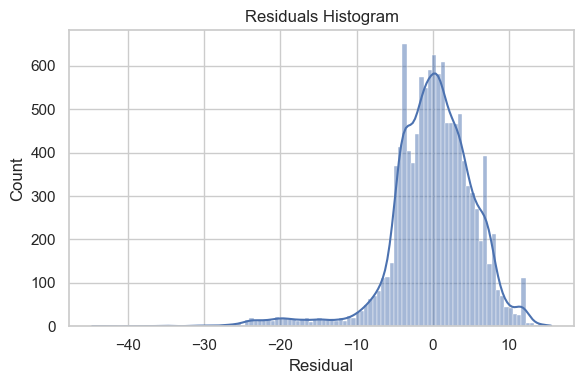

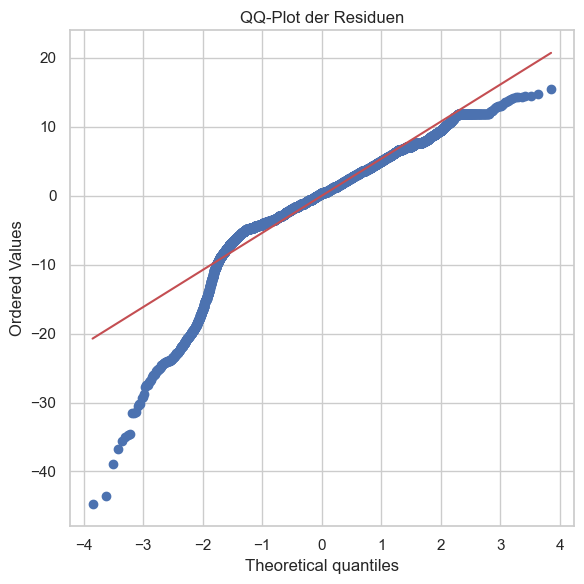

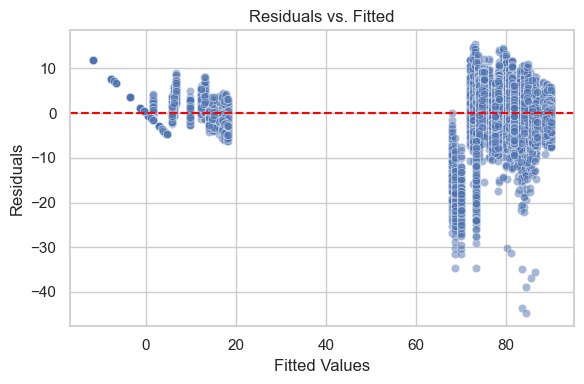

In [22]:
# %%  
# 6) Residual-Diagnostik: Histogramm, QQ-Plot, Residuals vs. Fitted
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Histogramm der Residuen
plt.figure(figsize=(6,4))
sns.histplot(ols_clust.resid, kde=True)
plt.title("Residuals Histogram")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# QQ-Plot
plt.figure(figsize=(6,6))
stats.probplot(ols_clust.resid, dist="norm", plot=plt)
plt.title("QQ-Plot der Residuen")
plt.tight_layout()
plt.show()

# Residuals vs. Fitted
fitted = ols_clust.fittedvalues
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted, y=ols_clust.resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs. Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


In [23]:
# %%  
# 5) Heteroskedastizitätstest (Breusch–Pagan)
import statsmodels.stats.api as sms

# BP-Test auf den ungeclustered OLS-Residuals
bp_test = sms.het_breuschpagan(ols.resid, ols.model.exog)
labels = ["Lagrange multiplier stat", "p-value", "f-value", "f p-value"]
print("=== Breusch–Pagan Test ===")
print(dict(zip(labels, bp_test)))


=== Breusch–Pagan Test ===
{'Lagrange multiplier stat': 2357.688995772194, 'p-value': 0.0, 'f-value': 244.85211013382477, 'f p-value': 0.0}


In [24]:
# 1) Skewness der Residuen berechnen
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import skew

# Daten laden & OLS (ohne Cluster for residuals)
df = pd.read_csv("bleu_scores_per_doc.csv")
df["system"] = df["technology"] + "–" + df["model"]
# (set categories wie gehabt…)

ols = smf.ols("bleu_score ~ C(system) + C(ambientVariant) + C(processedVolume)", data=df).fit()
resid = ols.resid

print("Skewness der Residuen:", skew(resid))


Skewness der Residuen: -1.3874776501841124
